In [ ]:
!pip install lightning

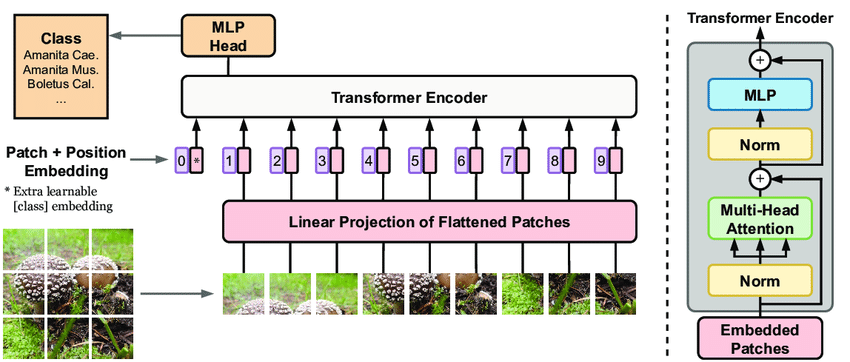

Here are some possible ideas for a **Quantum Vision Transformer**:


*   We could work directly inside the **Transformer Encoder**, using some **PQC layers in the MLP** (hybrid scheme - some classical layers downprojecting the hidden representations to the number of qubits). 
*   We could use a PQC for the **MultiheadAttention** (very similar to what we did in the Quantum GNN, but this would be slower - especially since we need multiple heads to guarantee a better stability of Attention, and since also we have limited QuBits for now, this would be a greater challenge, and would most likely end up hurting generalization. 
*   The convolutions could be done via quantum kernels, where each qubit is mapped to a cell.
*   The final option would be to **substitute the MLP head outside the transformer encoders** by PQC layers, and use this for the final classification.



In [2]:
import os
import urllib.request
from urllib.error import HTTPError

import matplotlib
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from IPython.display import set_matplotlib_formats
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torchvision import transforms
from torchvision.datasets import  MNIST

Seed set to 42
Seed set to 42


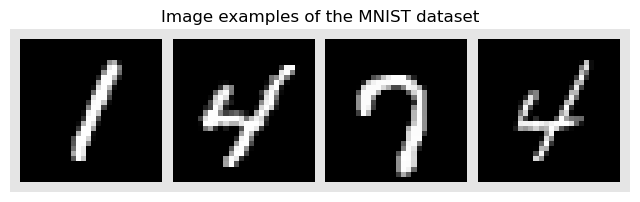

In [14]:
test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    ]
)
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        # transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.ToTensor(),
        # transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    ]
)
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = MNIST(root="datasets/mm", train=True, transform=train_transform, download=True)
val_dataset = MNIST(root="datasets/mm", train=True, transform=test_transform, download=True)
pl.seed_everything(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [55000, 5000])
pl.seed_everything(42)
_, val_set = torch.utils.data.random_split(val_dataset, [55000, 5000])

# Loading the test set
test_set = MNIST(root="datasets/mm", train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=64, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=64, shuffle=False, drop_last=False, num_workers=4)

# Visualize some examples
NUM_IMAGES = 4
MNIST_images = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(MNIST_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image examples of the MNIST dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

In [4]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.repeat(1, 3, 1, 1)
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x

In [5]:
class AttentionBlock(nn.Module):

    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads,
                                          dropout=dropout)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )


    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [16]:
import torch
import torch.nn as nn

# B -> Batch Size
# C -> Number of Input Channels
# IH -> Image Height
# IW -> Image Width
# P -> Patch Size
# E -> Embedding Dimension
# S -> Sequence Length = IH/P * IW/P
# Q -> Query Sequence length
# K -> Key Sequence length
# V -> Value Sequence length (same as Key length)
# H -> Number of heads
# HE -> Head Embedding Dimension = E/H


class EmbedLayer(nn.Module):
    def __init__(self, n_channels, embed_dim, image_size, patch_size):
        super().__init__()
        self.conv1 = nn.Conv2d(n_channels, embed_dim, kernel_size=patch_size, stride=patch_size)  # Pixel Encoding
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim), requires_grad=True)  # Cls Token
        self.pos_embedding = nn.Parameter(torch.zeros(1, (image_size // patch_size) ** 2 + 1, embed_dim), requires_grad=True)  # Positional Embedding

    def forward(self, x):
        x = self.conv1(x)  # B C IH IW -> B E IH/P IW/P (Embedding the patches)
        x = x.reshape([x.shape[0], x.shape[1], -1])  # B E IH/P IW/P -> B E S (Flattening the patches)
        x = x.transpose(1, 2)  # B E S -> B S E 
        x = torch.cat((torch.repeat_interleave(self.cls_token, x.shape[0], 0), x), dim=1)  # Adding classification token at the start of every sequence
        x = x + self.pos_embedding  # Adding positional embedding
        return x


class SelfAttention(nn.Module):
    def __init__(self, embed_dim, n_attention_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_attention_heads = n_attention_heads
        self.head_embed_dim = embed_dim // n_attention_heads

        self.queries = nn.Linear(self.embed_dim, self.head_embed_dim * self.n_attention_heads, bias=True)
        self.keys = nn.Linear(self.embed_dim, self.head_embed_dim * self.n_attention_heads, bias=True)
        self.values = nn.Linear(self.embed_dim, self.head_embed_dim * self.n_attention_heads, bias=True)

    def forward(self, x):
        m, s, e = x.shape

        xq = self.queries(x).reshape(m, s, self.n_attention_heads, self.head_embed_dim)  # B, Q, E -> B, Q, H, HE
        xq = xq.transpose(1, 2)  # B, Q, H, HE -> B, H, Q, HE
        xk = self.keys(x).reshape(m, s, self.n_attention_heads, self.head_embed_dim)  # B, K, E -> B, K, H, HE
        xk = xk.transpose(1, 2)  # B, K, H, HE -> B, H, K, HE
        xv = self.values(x).reshape(m, s, self.n_attention_heads, self.head_embed_dim)  # B, V, E -> B, V, H, HE
        xv = xv.transpose(1, 2)  # B, V, H, HE -> B, H, V, HE

        # Compute Attention Matrix
        xk = xk.transpose(-1, -2)  # B, H, K, HE -> B, H, HE, K
        x_attention = torch.matmul(xq, xk)  # B, H, Q, HE  *  B, H, HE, K -> B, H, Q, K

        x_attention /= float(self.head_embed_dim) ** 0.5
        x_attention = torch.softmax(x_attention, dim=-1)

        # Compute Attention Values
        x = torch.matmul(x_attention, xv)  # B, H, Q, K * B, H, V, HE -> B, H, Q, HE

        # Format the output
        x = x.transpose(1, 2)  # B, H, Q, HE -> B, Q, H, HE
        x = x.reshape(m, s, e)  # B, Q, H, HE -> B, Q, E
        return x


class Encoder(nn.Module):
    def __init__(self, embed_dim, n_attention_heads, forward_mul):
        super().__init__()
        self.attention = SelfAttention(embed_dim, n_attention_heads)
        self.fc1 = nn.Linear(embed_dim, embed_dim * forward_mul)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * forward_mul, embed_dim)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = x + self.attention(self.norm1(x)) # Skip connections
        x = x + self.fc2(self.activation(self.fc1(self.norm2(x))))  # Skip connections
        return x


class Classifier(nn.Module):
    def __init__(self, embed_dim, n_classes):
        super().__init__()
        # Newer architectures skip fc1 and activations and directly apply fc2.
        self.fc1 = nn.Linear(embed_dim, embed_dim)
        self.activation = nn.Tanh()
        self.fc2 = nn.Linear(embed_dim, n_classes)

    def forward(self, x):
        x = x[:, 0, :]  # Get CLS token
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x


class VisionTransformer(nn.Module):
    def __init__(self, n_channels, embed_dim, n_layers, n_attention_heads, forward_mul, image_size, patch_size, n_classes):
        super().__init__()
        self.embedding = EmbedLayer(n_channels, embed_dim, image_size, patch_size)
        self.encoder = nn.Sequential(*[Encoder(embed_dim, n_attention_heads, forward_mul) for _ in range(n_layers)], nn.LayerNorm(embed_dim))
        self.norm = nn.LayerNorm(embed_dim) # Final normalization layer after the last block
        self.classifier = Classifier(embed_dim, n_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.encoder(x)
        x = self.norm(x)
        x = self.classifier(x)
        return x

In [17]:
class ViT(pl.LightningModule):

    def __init__(self, model_kwargs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = VisionTransformer(**model_kwargs)
        self.example_input_array = next(iter(train_loader))[0]

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,150], gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(f'{mode}_loss', loss)
        self.log(f'{mode}_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

In [18]:
def train_model(**kwargs):
    trainer = pl.Trainer(default_root_dir="", 
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=180,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                    LearningRateMonitor("epoch")])
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

   
    pl.seed_everything(42) # To be reproducable
    model = ViT(**kwargs)
    trainer.fit(model, train_loader, val_loader)
    model = ViT.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

In [19]:
device = "cuda"

In [30]:
model, results = train_model(
    model_kwargs={
        "embed_dim": 256,
        "forward_mul": 2,
        "n_attention_heads": 8,
        "n_layers": 6,
        "patch_size": 4,
        "n_channels": 1,
        # "n_patches": 64,
        "n_classes": 10,
        # "dropout": 0.2,
        "image_size": 28
    },
    lr=3e-4,
)
print("ViT results", results)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type              | Params | In sizes        | Out sizes
--------------------------------------------------------------------------
0 | model | VisionTransformer | 2.9 M  | [64, 1, 28, 28] | [64, 10] 
--------------------------------------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.419    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/jogi/anaconda3/envs/majors/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

ViT results {'test': 0.9359999895095825, 'val': 0.923799991607666}


To do a quantum Vision Transformer, here are some possible ideas:


*   We could embed some PQC layers in the linear layers, in the AttentionBlock. 
*   We could use PQC for the MultiheadAttention, but this would be slower, and since we have limited QuBits, the hidden representations in the Attention mechanism would be very limited, hurting generalization.
*   Substitue the MLP head by PQC layers.



In [ ]:
"""
    Let's revisit, for example, our implementation of the Embedding layer.
"""
class EmbedLayer(nn.Module):
    def __init__(self, n_channels, embed_dim, image_size, patch_size):
        super().__init__()
        self.conv1 = nn.Conv2d(n_channels, embed_dim, kernel_size=patch_size, stride=patch_size)  # Pixel Encoding
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim), requires_grad=True)  # Cls Token
        self.pos_embedding = nn.Parameter(torch.zeros(1, (image_size // patch_size) ** 2 + 1, embed_dim), requires_grad=True)  # Positional Embedding

    def forward(self, x):
        x = self.conv1(x)  # B C IH IW -> B E IH/P IW/P (Embedding the patches)
        x = x.reshape([x.shape[0], x.shape[1], -1])  # B E IH/P IW/P -> B E S (Flattening the patches)
        x = x.transpose(1, 2)  # B E S -> B S E 
        x = torch.cat((torch.repeat_interleave(self.cls_token, x.shape[0], 0), x), dim=1)  # Adding classification token at the start of every sequence
        x = x + self.pos_embedding  # Adding positional embedding
        return x
    
"""
    We can see above, that the very first step is a 2d-convolution. Now, if we revisit the paper "Quantum Convolutional Neural Networks",
    by ... (ref ...), then perhaps the very first step could be to put quantum kernels right there.
    
    Another idea would be to also use the Quantum Attention Mechanism proposed in the earlier task .... Instead of having a query-key regular
    dot-product, we could use a SWAP test as a measure of Fidelity.
"""